# Cat vs. Dog classification

In [32]:
# the useful modules are imported

import os, time, random, shutil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

## Options

In [53]:
# options 

args = {}
args['data'] = './catdog_resized/'
args['batch_size'] = 16
args['workers'] = 2
args['lr'] = 1e-3
args['weight_decay'] = 1e-4
args['epochs'] = 2
args['print_freq'] = 500

# Data

In [34]:
# Data loading code
traindir = os.path.join(args['data'], 'train')
valdir = os.path.join(args['data'], 'val')
testdir = os.path.join(args['data'], 'test')

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_loader = data.DataLoader(
    datasets.ImageFolder(traindir,
                         transforms.Compose([
                             transforms.RandomResizedCrop(224),
                             transforms.RandomHorizontalFlip(),
                             transforms.ToTensor(),
                             normalize,
                         ])),
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=args['workers'],
    pin_memory=True)

val_loader = data.DataLoader(
    datasets.ImageFolder(valdir,
                         transforms.Compose([
                             transforms.Resize(256),
                             transforms.CenterCrop(224),
                             transforms.ToTensor(),
                             normalize,
                         ])),
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=args['workers'],
    pin_memory=True)

In [35]:
def accuracy(y_pred, y_actual, topk=(1, )):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = y_actual.size(0)

    _, pred = y_pred.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(y_actual.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))

    return res


# Train API

In [36]:

def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (images, target) in enumerate(tqdm(train_loader)):
        # measure data loading time
        data_time.update(time.time() - end)

        image_var = Variable(images)
        label_var = Variable(target)

        # compute y_pred
        y_pred = model(image_var)
        loss = criterion(y_pred, label_var)

        # measure accuracy and record loss
        prec1, prec1 = accuracy(y_pred.data, target, topk=(1, 1))
        losses.update(loss.data[0], images.size(0))
        acc.update(prec1[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args['print_freq'] == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Accuracy {acc.val:.3f} ({acc.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time, data_time=data_time, loss=losses, acc=acc))



# Validation API

In [37]:

def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (images, labels) in enumerate(tqdm(val_loader)):
        image_var = Variable(images, volatile=True)
        label_var = Variable(labels, volatile=True)

        # compute y_pred
        y_pred = model(image_var)
        loss = criterion(y_pred, label_var)

        # measure accuracy and record loss
        prec1, temp_var = accuracy(y_pred.data, labels, topk=(1, 1))
        losses.update(loss.data[0], images.size(0))
        acc.update(prec1[0], images.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args['print_freq'] == 0:
            print('TrainVal: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Accuracy {acc.val:.3f} ({acc.avg:.3f})'.format(
                      i, len(val_loader), batch_time=batch_time, loss=losses, acc=acc))

    print(' * Accuracy {acc.avg:.3f}'.format(acc=acc))

    return acc.avg

In [38]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

# Model

In [39]:
class CatDogNet(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.alexnet(pretrained=pretrained).features
        for param in self.features.parameters():
            param.requires_grad = False
        
        self.classifier = nn.Linear(256*6*6, 2)
    
    def forward(self, img):
        out = self.features(img)
        #print(out.size())
        out = out.view(out.size(0), -1)
        return self.classifier(out)

model = CatDogNet(pretrained=True)

# Train and Validate in a loop

In [54]:
# define loss function (criterion) and pptimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.classifier.parameters(), args['lr'], weight_decay=args['weight_decay'])

best_prec1 = 0

for epoch in range(args['epochs']):
    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch)

    # evaluate on validation set
    prec1 = validate(val_loader, model, criterion)

    # remember best Accuracy and save checkpoint
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_prec1': best_prec1,
    }, is_best)


  0%|          | 1/1407 [00:00<22:32,  1.04it/s]

Epoch: [0][0/1407]	Time 0.964 (0.964)	Data 0.127 (0.127)	Loss 1.8577 (1.8577)	Accuracy 75.000 (75.000)


  1%|          | 8/1407 [00:06<18:12,  1.28it/s]Process Process-24:
Process Process-23:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/arul/miniconda2/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/arul/miniconda2/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/arul/miniconda2/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/arul/miniconda2/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/arul/miniconda2/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    r = index_queue.get()
  File "/home/arul/miniconda2/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    r = inde

KeyboardInterrupt: 

# Test with Random images

In [45]:
def get_random_test_images(root, count):    
    filenames = [os.path.join(root, filename) for filename in os.listdir(root)
                        if filename.endswith('jpg')]
    
    random.shuffle(filenames)
    return filenames[:count]

In [50]:
test_transform = transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.ToTensor(),
                            normalize,
                        ])

def classify_image(img_path):
    # API to classify an image
    model.eval()
    img = Image.open(img_path)
    transformed_img = test_transform(img)    
    var_img = Variable(transformed_img.unsqueeze(0))
    out = model(var_img)
    
    # display the image
    plt.imshow(np.asarray(img))
    plt.show()
    # print top 10 classes
    if out.data[0][0] > out.data[0][1]:
        print("cat")
    else:
        print("dog")

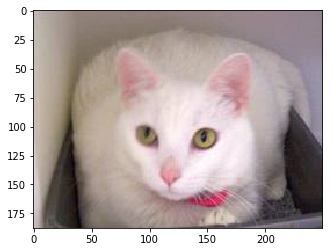

cat


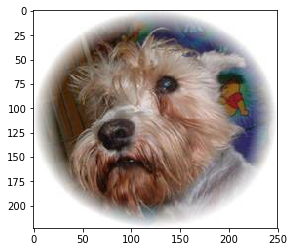

dog


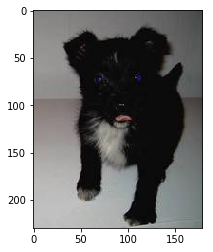

cat


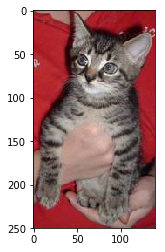

cat


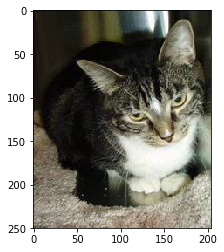

cat


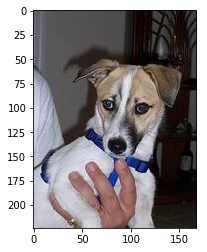

dog


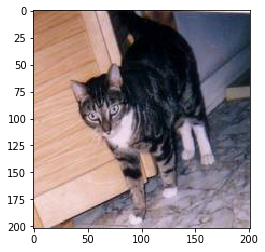

cat


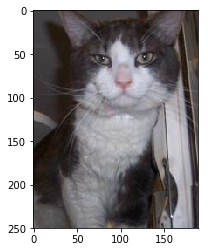

cat


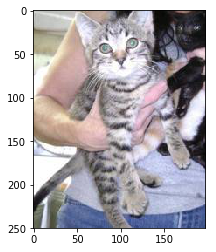

cat


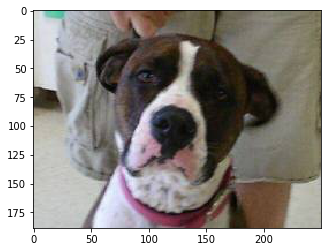

dog


In [52]:
test_img_paths = get_random_test_images(testdir, 10)
[classify_image(img_path) for img_path in test_img_paths];